In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch, time, os
import numpy as np
import matplotlib.pyplot as plt
from first_gm import SM_World, plot_SM, plot_raster, gaussian_kernel, tensor2spikeship

## Raster plot generative model with a superposition of SMs
### Parameters

In [3]:
class world_params:
    N_pre = 100 # number of neurons in the RP
    N_delays = 51 # number of timesteps in the SM (must be an odd number for convolutions)
    N_kernels = 2 # number of SM used for RP generation
    
    p_input = .05 # global probability of having a spike in the timebins of the RP as input
    sm_ratio = .5 # probability of a spike as input to belong to the SM
    p_spontaneous =  p_input*(1-sm_ratio)
    p_spike_in_motif = p_input*sm_ratio # probability of having a spike in the timebins of the SM
    
    avg_N_spikes = p_spike_in_motif*N_delays*N_pre
    std_N_spikes = 1

    N_timesteps =  N_delays # number of timesteps in the RP
    
    avg_precision = 10 # average precision for the spikes in the SM (inverse of variance of the gaussian distribution defined for 1 spike)
    std_precision = 1 # variance for the precision
    
    seed = 4815162342 # seed

In [4]:
class SM_World:
    def __init__(self, opt, add_coef = None):
        # initialization of the parameters + drawing of the kernels
        # here one of the kernels is a combination of the 2 first ones with parameter add_coef ([0,1])
        self.opt: Params = opt
        if add_coef:
            self.kernels = torch.zeros(self.opt.N_kernels+1, self.opt.N_pre, self.opt.N_delays)
        else:
            self.kernels = torch.zeros(self.opt.N_kernels, self.opt.N_pre, self.opt.N_delays)
            
        for k in range(self.kernels.shape[0]):
            nb_spikes = int(torch.normal(torch.Tensor([self.opt.avg_N_spikes]), torch.Tensor([self.opt.std_N_spikes])).abs())
            addr, delay, precision = (torch.randint(self.opt.N_pre, [nb_spikes]), torch.randint(self.opt.N_delays, [nb_spikes]), torch.normal(torch.ones([nb_spikes])*self.opt.avg_precision, torch.ones([nb_spikes])*self.opt.std_precision).abs())
            for s in range(nb_spikes):
                self.kernels[k, addr[s], :] += gaussian_kernel(self.opt.N_delays, delay[s], 1/precision[s])
            if self.kernels[k, :, :].max()>1: self.kernels[k, :,:]/=self.kernels[k, :, :].max()
        if add_coef:
            
            self.kernels[-1, :, :] = (1-add_coef)*self.kernels[0, :, :] + add_coef*self.kernels[1, :, :]
                
    def draw_input_one_sm(self, N_trials = 1, do_channels = False):
        
        spontaneous_activity = torch.bernoulli(torch.ones([N_trials, self.opt.N_pre, self.opt.N_timesteps])*self.opt.p_spontaneous)
        
        labels = torch.randint(self.kernels.shape[0], [N_trials])
        
        if do_channels:
            input_rp_with_channels = torch.zeros([self.kernels.shape[0]+1, N_trials, self.opt.N_pre, self.opt.N_timesteps])
            for k in labels.unique():
                indices = labels==k
                trials = torch.bernoulli(self.kernels[k,:,:].unsqueeze(0).repeat(indices.sum(),1,1))
                input_rp_with_channels[k+1,indices,:,:] = trials
                input_rp_with_channels[0,indices,:,:] = spontaneous_activity[indices,:,:]
            return input_rp_with_channels, labels
        else:
            input_rp = torch.zeros([N_trials, self.opt.N_pre, self.opt.N_timesteps])
            for k in labels.unique():
                indices = labels==k
                trials = torch.bernoulli(self.kernels[k,:,:].unsqueeze(0).repeat(indices.sum(),1,1))
                input_rp[indices,:,:] = torch.max(trials, spontaneous_activity[indices])
            return input_rp, labels

TODO: change something in the formula with SM_ratio

### Generative model without motif non overlapping

In [5]:
N_trials = 10
add_coef = .2 # coeff for the combination of the 2 patterns/motifs -> hyperparameter of the SM_World class (could be defined as random is necessary)

opt = world_params()
world = SM_World(opt, add_coef = add_coef)
input_rp, labels = world.draw_input_one_sm(N_trials = N_trials, do_channels = True) # do_channels = True for colored plot only

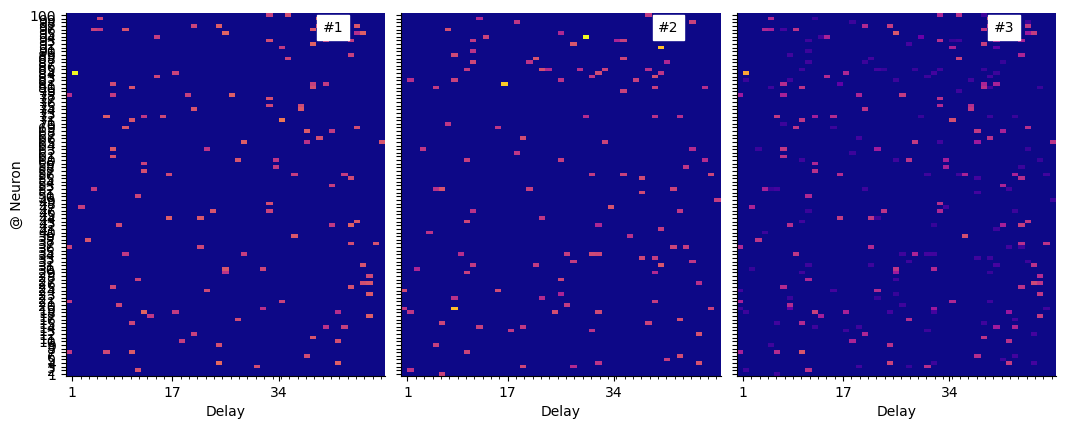

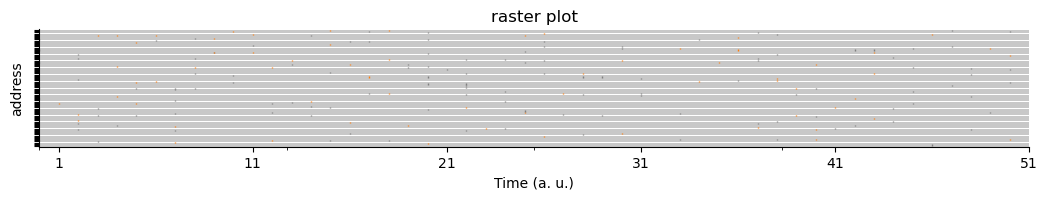

In [6]:
plot_SM(world.kernels, N_show = opt.N_kernels+1, figsize = (12, 5));
plot_raster(input_rp, colored=True);

### Define the HDSNN model

Hyperparameters: 
- you have to set the size of the kernels (N_pre, N_delays, N_neurons)
- you have to set a threshold or a number of output spikes for top_k (can be assimilated to an adaptative threshold)

In [7]:
class HDSNN1D(torch.nn.Module):
    def __init__(self, N_pre, N_delays, N_neurons, SMs=None, do_bias=True, output='sigma', homeo_gain=False, threshold=None, tau_homeo = 10, device='cpu'): 
        super(HDSNN1D, self).__init__()
        self.device=device
        self.kernel_size = (N_neurons, N_pre, N_delays)
        padding_conv = N_delays
        padding_transposed = 0
        padding_mode = 'zeros'
        self.threshold = threshold
        self.homeo_gain = homeo_gain
        self.cumhisto = (torch.ones([N_neurons,1])/N_neurons).to(device)
        self.tau_homeo = tau_homeo

        self.conv_layer = torch.nn.Conv1d(N_pre, N_neurons, kernel_size=self.kernel_size, padding=padding_conv, padding_mode=padding_mode, bias=do_bias, device=device)
        
        if output=='sigma': 
            self.nl = torch.nn.Sigmoid()
        else: 
            self.nl = torch.nn.Softmax(dim=0)
            
        self.reconstruction_layer = torch.nn.ConvTranspose1d(N_neurons, N_pre, kernel_size=self.kernel_size, padding=padding_transposed, bias=do_bias, device=device)
        
        if SMs is not None:
            weight_init = SMs
            self.conv_layer.weight = self.reconstruction_layer.weight = torch.nn.Parameter(weight_init.to(device), requires_grad=True)
        else:
            self.conv_layer.weight = self.reconstruction_layer.weight = torch.nn.Parameter(torch.rand(self.kernel_size).to(device), requires_grad=True)
        
    def forward(self, a, k): 
        # convolution with LR
        logit_b = self.conv_layer(a)[:,:,:-self.kernel_size[2]-1]
        p_b = self.nl(logit_b)
        if self.homeo_gain:
            p_b = homeo_gain_control(self.cumhisto).to(self.device)*p_b
        
        # select the top k values for spikes
        if self.threshold:
            output_spikes = p_b>self.threshold
        else: 
            output_spikes = topk_p_raster(p_b, k)
        
        # recontruct the input with logits
        estimated_input = self.reconstruction_layer(output_spikes.to(torch.float32))
        estimated_input = torch.roll(estimated_input, -self.kernel_size[2], dims=2)[:,:,:-self.kernel_size[2]+1]
        
        if (self.conv_layer.weight-self.reconstruction_layer.weight).sum()!=0:
            print('ERROR: weights are not shared')
            
        if self.homeo_gain:
            self.cumhisto[:,0] = (1-1/self.tau)*self.cumhisto[:,0]+1/self.tau*output_spikes.sum(dim=1)/output_spikes.sum()
        
        return p_b, output_spikes, estimated_input

In [12]:
def learn_offline(path, env, model, criterion, N_learnsteps, lr, lambdaz=[0,0,0,0,0], device = 'cpu'):

    if os.path.isfile(path + '.pth'):
        model.load_state_dict(torch.load(path + '.pth', map_location=torch.device(device)))
        LOSS = torch.load(path + '_loss.pth')
    else:
        LOSS = []
        model = model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        
        lambda_2_weights, lambda_1_weights, lambda_1_proba, lambda_1_spikes, lambda_entropy_p_b = lambdaz
        
        for i_step in range(N_learnsteps):
            # generate the corresponding raster plot = what is observed
            a, true_b = env.draw_input_one_sm()
            a = a.to(device)
            # learn the SMs
            optimizer.zero_grad()

            p_b, output_spikes, a_hat = model(a, None) 
            
            a_hat = a_hat.to(device)
            
            L2_penalty_proba = lambda_1_proba*torch.norm(p_b, 2) # for output probabilities to be small
            L1_penalty_spikes = lambda_1_spikes*torch.sum(output_spikes) # for small number of output spikes
            
            sum_p_b = output_spikes.float().mean(dim=1)#
            entropy = (sum_p_b/sum_p_b.sum()*torch.log(sum_p_b/sum_p_b.sum())).nanmean()
            entropy_penalty = lambda_entropy_p_b*entropy # for small entropy accross output neurons
            #print(sum_p_b, entropy.item())
            
            L1_penalty_weights = lambda_1_weights*torch.norm(model.reconstruction_layer.weight ,1)
            L2_penalty_weights = lambda_2_weights*torch.norm(model.reconstruction_layer.weight ,2)
            #torch.norm(trained_layer_of_neurons.reconstruction_layer.weight.data ,2, dim=(2,3)).sum()
            
            loss = criterion(a, a_hat) + L2_penalty_proba + L1_penalty_spikes + L2_penalty_weights + L1_penalty_weights + entropy_penalty

            LOSS.append(loss.item())
            
            loss.backward()
            optimizer.step()
            
            # normalization of the kernels 
            #model.reconstruction_layer.weight = model.conv_layer.weight = torch.nn.Parameter(torch.nn.functional.normalize(model.reconstruction_layer.weight, dim=(1,2), p=1), requires_grad=True)

            if i_step % (N_learnsteps//10) == 0:
                print(f'Train Epoch [{i_step:06d}/{N_learnsteps:06d}]\tLoss: {loss.item():.3e}')#\t(reg: {loss_reg.item():.3e})\tAccuracy: {torch.mean((b_hat_bin == b_true)*1.):.3e}\tTP: {torch.mean(b_hat_bin[b_true==1]*1.):.3e}')
                print(criterion(a, a_hat).item(), L2_penalty_weights.item(), L1_penalty_weights.item(), L2_penalty_proba.item(), L1_penalty_spikes.item(), entropy_penalty.item())
        torch.save(model.state_dict(), path + '.pth')
        torch.save(LOSS, path + '_loss.pth')
    return model, LOSS


In [13]:
N_neurons = world.opt.N_kernels
do_bias = True
output = 'softmax'
homeo_gain = False
threshold = None

N_learnsteps = 10000
learning_rate = .001
criterion = torch.nn.MSELoss()
lambdaz=[0,0,1,0,0] # lambda_2_weights, lambda_1_weights, lambda_1_proba, lambda_1_spikes, lambda_entropy_p_b
naive_layer_of_neurons = HDSNN1D(world.opt.N_pre, world.opt.N_delays, N_neurons, do_bias=do_bias, output=output, homeo_gain=homeo_gain, threshold=threshold)
path = f'results/test_{learning_rate}_{lambdaz}_{N_learnsteps}_{criterion}_{naive_layer_of_neurons.threshold}_{naive_layer_of_neurons.homeo_gain}_{naive_layer_of_neurons.tau_homeo}_{naive_layer_of_neurons.nl}_{N_neurons}'

trained_layer_of_neurons, loss = learn_offline(path, world, naive_layer_of_neurons, criterion, N_learnsteps, learning_rate, lambdaz)

NameError: name 'topk_p_raster' is not defined

In [ ]:
def plot_results(world, loss, trained_layer_of_neurons):
    plot_SM(world.kernels, figsize = (12, 2));
    a, true_b = world.draw_input()

    fig_loss, ax_loss = plt.subplots(figsize=(12.75,2));
    ax_loss.plot(loss);
    ax_loss.set_title('loss');
    plot_SM(trained_layer_of_neurons.conv_layer.weight.data.squeeze(1).detach().cpu().flip(2), figsize=(12,2), N_show = trained_layer_of_neurons.kernel_size[0]);
    b, spikes, estimated_input = trained_layer_of_neurons(a, None)
    plot_raster(a.detach().cpu().numpy(), title = 'input raster plot');
    plot_raster(spikes.detach().cpu().numpy(), title = 'detection of spiking motifs');
    fig, ax = plt.subplots(2, 1, figsize=(12.6,4))
    for i in range(len(b)):
        ax[0].plot(b[i].detach().cpu().numpy());
    ax[1].imshow(estimated_input[0,:,:].detach().cpu().numpy(), aspect='auto');

    ax[0].set_xticks([]);
    ax[0].set_xlim(0,b.shape[1]);
    ax[0].set_title('output probability');
    ax[1].set_title('reconstructed input');
    plt.show();

In [ ]:
trained_layer_of_neurons.device='cpu'
trained_layer_of_neurons.cumhisto = trained_layer_of_neurons.cumhisto.to('cpu')
plot_results(world, loss, trained_layer_of_neurons.to('cpu'))
plt.hist(trained_layer_of_neurons.conv_layer.weight.data.ravel().detach().cpu());